## README
* this is the test notebook for updating emission line ratios based on Sean's codes
* working on this on Apr 18, 2022
* Here is the instruction from Joel
- [ ] To calculate mstar, it is a little tricky -- you need to first call FSPS to get the ratio of stellar mass to total mass formed (the units of the massmet[0] parameter are unfortunately total mass formed). So first generate a spectrum using model.predict() with the correct theta, this will have the following format:
    - spec, mags, sm = model.predict()...
    - The key factor is "sm" -- this is the ratio of stellar mass to total mass formed.
    - To get stellar mass, you then do: stellar_mass = np.log10(sm * 10**theta[logmass_index])
    - calculate SFR from the nonparametric Prospector models
    - A_V = dust2 * 1.086

- [ ] That should let you calculate the inputs for any given set of Prospector parameters. You'll need to write some code to do this, which we will then tuck into Prospector below... Did you follow the discussion about doublets and atomic ratios above -- do you feel comfortable specifying the correct luminosities using these prescriptions?

- [ ] Now, when that is settled, we can hack the Prospector code to take these emission line luminosities as inputs. You'll need to 
    - modify ```{/prospector/prospect/model/sedmodel.py}``` and reinstall Prospector after any modifications. 
    - Line 111 is where Prospector pulls the emission line luminosities from FSPS. 
    - What I would suggest doing is adding some code after this to replace some of these line luminosities with your own calculations from Sean's prescriptions. 
    - Note that this also gives you access to `sm`, so you can calculate the stellar mass right there as inputs to Sean's code. 
    
- [ ] The existing list of lines is at `$SPS_HOME/data/emlines_info.dat`. I _think_ all of the needed lines are already in FSPS but you may have to add some new ones if they're not already in the list. The wavelength units are angstroms (rest frame!) and the luminosity units need to be in Lsun / (mass formed).

- [ ] You will do one more thing to make sure that 
    - Prospector IS adding the emission lines to the spectrum 
    - and FSPS is NOT adding them (both codes have the capacity so we need to be careful here). 
    - First, make sure the 'nebemlineinspec' parameter is set to False -- this ensures that FSPS will not add lines to the spectrum. 
    - There is a really tangled set of boolean flags that control whether Prospector adds emission lines itself (you can see them in the `predict` function of the sedmodel file). 
    - I _think_ we can force Prospector to add emission lines instead by doing the following before calling model.predict:
        
    > obs['wavelength'] = sps.wavelength
    > obs['spectrum'] = np.zeros_like(sps.wavelength)

- [ ] I strongly suggest testing this to make sure that you're replacing the emission line luminosities properly, and that emission lines are being added (e.g., replace one luminosity with zero and make sure the resulting spectrum looks reasonable). It wouldn't surprise me if we had to iterate on this hack since the Prospector logic controlling emission line addition is quite complex (but hopefully we got it right the first time).  

In [1]:
import pickle, sys, os
import numpy as np
import pandas as pd
import prospect
import pfs_spectra_params 

from astropy.io import fits
from sedpy import observate
import math

In [2]:
def Choi_2014(logmstar):
    return logmstar*0.11881615 - 1.0826891415131317

def Matthee_2018(logmstar, logssfr):
    return -0.282*(logmstar-10.0) + 0.290*(logssfr+logmstar) + 0.163

def est_afe(logmstar, logssfr):
    if logssfr > -10.5:
        return Matthee_2018(logmstar, logssfr)
    else:
        return Choi_2014(logmstar)
est_afe = np.vectorize(est_afe)

In [3]:
    cat=pickle.load(open('../input/prospector_3dhst_bestfit_catalog.pickle', 'rb'))
    print('display first 5 objects')
    print(cat.keys())
    for ikey in cat.keys():
        print(ikey, cat[ikey][:5])

display first 5 objects
dict_keys(['dust1_fraction', 'dust2', 'dust_index', 'gas_logz', 'logsfr_ratios_1', 'logsfr_ratios_2', 'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5', 'logsfr_ratios_6', 'z', 'name', 'log_stellarmass', 'log_ssfr', 'logmass', 'logzsol'])
dust1_fraction [1.24274787 1.18358962 1.21648014 0.85535957 0.82708048]
dust2 [1.30110954 1.45282801 0.25680514 0.06070061 0.45792446]
dust_index [-0.25120421  0.06470886  0.14646028 -0.72055     0.35590058]
gas_logz [ 0.11262719 -0.16669341 -0.67486781  0.2276225  -1.01314053]
logsfr_ratios_1 [0.28752652 0.13026776 0.14127212 0.03998617 0.47830477]
logsfr_ratios_2 [ 0.36074601  0.02157012 -0.07948795 -0.02777394  0.02428069]
logsfr_ratios_3 [0.00788727 0.10336385 0.23229781 0.07597261 0.08781713]
logsfr_ratios_4 [0.09498663 0.13472415 0.24671893 0.05407279 0.12071265]
logsfr_ratios_5 [-0.39796617  0.17047266 -0.04688681 -0.27787392 -0.22250321]
logsfr_ratios_6 [ 0.17108806  0.02099638 -0.11346972 -0.3261988  -0.11406414]

In [ ]:
    mod = pfs_spectra_params.build_model(objname='test',afe_on=True)
    #mod.params['nebemlineinspec'] = True
    #mod.params['nebemlineinspec'] = False
    
    sps = pfs_spectra_params.build_sps()
    print('finish building sps')
    # FILTERS
    # UgrizyJ, IRAC1, IRAC2
    filters = ['bessell_U']
    filters +=  ['sdss_'+filt+'0' for filt in ['g','r','i','z']]
    filters += ['uvista_y_cosmos','UDS_J']
    filters += ['IRAC_CH1','IRAC_CH2']

In [ ]:
    ### SPECTRUM
    hdu = fits.open('../input/noise_spec_12hr.fits')
    wave_obs = hdu[1].data['WAV']
    #detector_noise = hdu[1].data['ERR']/1e-23/3631 * wave_obs**2/(3e18) # erg/s/cm^2/A

    ### Remove repeated wavelength values
    print('REMOVING REPEATED WAVELENGTH VALUES')
    _, idx = np.unique(wave_obs, return_index=True)
    wave_obs = wave_obs[idx]
    #detector_noise = detector_noise[idx]

    ### define masks
    mask = np.ones(len(wave_obs),dtype=bool)
    phot_mask = np.ones(len(filters),dtype='bool')

    obs = {'filters': []}
    for filt in filters:
        #print('loading '+filt)
        obs['filters'] += observate.load_filters([filt])
    obs['wave_effective'] = np.array([filt.wave_effective for filt in obs['filters']])
    obs['phot_mask'] = phot_mask
    if wave_obs is not None:
        obs['wavelength'] = wave_obs[mask]
        obs['mask'] = np.ones(mask.sum(),dtype=bool)
    else:
        obs['wavelength'] = None

In [ ]:
    """
    theta_all_dict = {}
    for iparams in ['logzsol', 'dust2', 'logsfr_ratios_1', 
                    'logsfr_ratios_2', 'logsfr_ratios_3', 
                    'logsfr_ratios_4', 'logsfr_ratios_5', 
                    'logsfr_ratios_6', 'logmass']:
        theta_all_dict[iparams] = np.copy(cat[iparams])
    theta_all_dict['zred'] = np.copy(cat['z'])
    
    # cat['log_ssfr'] is actually just ssfr, not logarithmic ssfr
    theta_all_dict['afe'] = est_afe(cat['log_stellarmass'], np.log10(cat['log_ssfr']))
    theta_all_dict['afe'] = np.clip(np.copy(theta_all_dict['afe']), -0.2, 0.6)

    theta_all_dict['dust_index'] = np.copy(cat['dust_index'])
    theta_all_dict['dust1_fraction'] = np.copy(cat['dust1_fraction'])
    
    # based on the LEGA-C mass-FJ relation
    # Eq1 in https://arxiv.org/pdf/1811.07900.pdf says log σ =(−0.85 ± 0.11) + (0.29 ± 0.01) log M
    theta_all_dict['sigma_smooth'] = 10**(0.29 * np.copy(cat['log_stellarmass']) - 0.85)
    
    # fix gas_logz to stellar metallicity
    theta_all_dict['gas_logz'] = np.copy(cat['logzsol'])
    theta_all_dict['gas_logu'] = np.zeros(cat['z'].shape)-2
    theta_all_dict['eline_sigma'] = np.copy(theta_all_dict['sigma_smooth'])
    
    theta_all_df = pd.DataFrame.from_dict(theta_all_dict)
    theta_all_df = theta_all_df.reindex(columns=mod.theta_labels())
    theta_all_df.to_csv('theta_all.csv')
    """
    
    theta_all_df = pd.read_csv('theta_all.csv')  
    theta_all_df = theta_all_df.reindex(columns=mod.theta_labels())

In [ ]:
i = 13

In [ ]:
        obs['redshift'] = float(theta_all_df['zred'][i])
        #obs['spectrum'] = np.zeros_like(obs['wavelength'])
        
        spec, photometric_fluxes, sm = mod.predict(theta =list(theta_all_df.loc[i].to_numpy()),
                                                   obs = obs,
                                                   sps = sps)

In [31]:
theta_all_df[['logsfr_ratios_1','logsfr_ratios_2','logsfr_ratios_3','logsfr_ratios_4',
              'logsfr_ratios_5','logsfr_ratios_6']].loc[13]

logsfr_ratios_1    0.177525
logsfr_ratios_2    1.236701
logsfr_ratios_3    0.166724
logsfr_ratios_4    0.149643
logsfr_ratios_5    0.318569
logsfr_ratios_6    0.389717
Name: 13, dtype: float64

In [38]:
i_logsfr_ratios =mod.params['logsfr_ratios']
mod.params

{'zred': array([0.6432]),
 'mass': array([6.58536105e+07, 1.02074907e+08, 1.59444659e+07, 3.13419361e+07,
        6.40800896e+07, 8.87962946e+07, 6.15487546e+06]),
 'logzsol': array([-1.18108328]),
 'dust2': array([1.22087858]),
 'sfh': array([3]),
 'imf_type': array([2]),
 'dust_type': array([4]),
 'logmass': array([8.57315737]),
 'agebins': array([[0.        , 7.4772    ],
        [7.4772    , 8.        ],
        [8.        , 8.46024027],
        [8.46024027, 8.92048055],
        [8.92048055, 9.38072082],
        [9.38072082, 9.84096109],
        [9.84096109, 9.88671858]]),
 'logsfr_ratios': array([0.1775249 , 1.23670064, 0.16672443, 0.14964298, 0.31856854,
        0.38971743]),
 'afe': array([0.49882969]),
 'dust_index': array([0.36172426]),
 'dust1': array([0.8556916]),
 'dust1_fraction': array([0.70088182]),
 'add_igm_absorption': array([1]),
 'smoothtype': array(['vel'], dtype='<U3'),
 'fftsmooth': array([ True]),
 'sigma_smooth': array([38.8212437]),
 'add_dust_emission': array

In [39]:
prospect.models.transforms.logsfr_ratios_to_sfrs(mod.params['logmass'], 
                                                 mod.params['logsfr_ratios'], 
                                                 mod.params['agebins'], )

array([2.19472245, 1.45832629, 0.08455788, 0.05760095, 0.04081188,
       0.01959829, 0.00798915])

In [44]:
mod.params.get('agebins',0)

array([[0.        , 7.4772    ],
       [7.4772    , 8.        ],
       [8.        , 8.46024027],
       [8.46024027, 8.92048055],
       [8.92048055, 9.38072082],
       [9.38072082, 9.84096109],
       [9.84096109, 9.88671858]])

In [40]:
10**(cat['log_stellarmass'][13]+np.log10(cat['log_ssfr'])[13])

0.4096978207097171

In [20]:
np.log10(cat['log_ssfr'][13]) + cat['log_stellarmass'][13]

-0.38753634616709576

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
list(theta_all_df.loc[i].to_numpy())

[0.6432,
 -1.181083282640693,
 1.220878579843719,
 8.573157374894405,
 0.1775249008273819,
 1.2367006401662104,
 0.1667244278187093,
 0.1496429836617706,
 0.3185685401889558,
 0.38971742613038,
 0.4988296893988002,
 0.3617242623018339,
 0.7008818154101344,
 38.821243696293976,
 -1.181083282640693,
 -2.0,
 38.821243696293976]

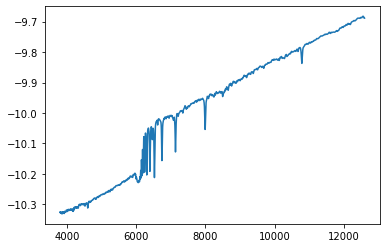

In [15]:
plt.plot(obs['wavelength'], np.log10(spec))
#plt.xlim(4e3, 8e3)
#plt.ylim(-11, -9)

In [13]:
_eline_wave, _eline_lum = sps.get_galaxy_elines()

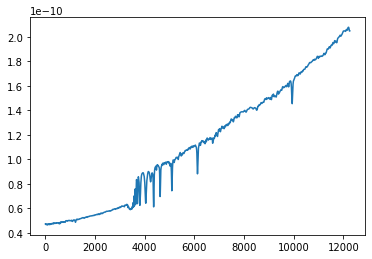

In [14]:
plt.plot(spec)

In [23]:
mod.theta_labels()

['zred',
 'logzsol',
 'dust2',
 'logmass',
 'logsfr_ratios_1',
 'logsfr_ratios_2',
 'logsfr_ratios_3',
 'logsfr_ratios_4',
 'logsfr_ratios_5',
 'logsfr_ratios_6',
 'afe',
 'dust_index',
 'dust1_fraction',
 'sigma_smooth',
 'gas_logz',
 'gas_logu',
 'eline_sigma']

In [41]:
mod.params.get('logmass',0)

array([10.83985788])

In [50]:
        _agebins = sps.params['agebins']
        nbins = _agebins.shape[0]

In [51]:
        i_log_totmass = mod.params.get('logmass',0)
        i_logsfr_ratios = mod.params.get('logsfr_ratios',0)
        sratios = 10**np.clip(i_logsfr_ratios, -100, 100)
        dt = (10**_agebins[:, 1] - 10**_agebins[:, 0])
        coeffs = np.array([ (1. / np.prod(sratios[:i])) * (np.prod(dt[1: i+1]) / np.prod(dt[: i])) for i in range(nbins)])
        m1 = (10**i_log_totmass) / coeffs.sum()
        masses = m1*coeffs
        sfrs = masses/dt

In [73]:
cat['log_ssfr'][i]

5.919858384133532e-10

In [75]:
10**(math.log10(cat['log_ssfr'][i]) + i_log_totmass)

array([40.94201358])

In [76]:
_agebins

array([[0.        , 7.4772    ],
       [7.4772    , 8.        ],
       [8.        , 8.41020802],
       [8.41020802, 8.82041603],
       [8.82041603, 9.23062405],
       [9.23062405, 9.64083207],
       [9.64083207, 9.68658956]])

In [69]:
i_log_totmass

array([10.83985788])

In [60]:
sfrs

array([40.55137181, 20.91601931,  9.11450372,  8.95046818,  7.19215638,
       17.9814741 , 12.12654929])

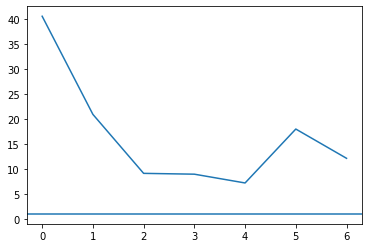

In [58]:

plt.plot(sfrs)
plt.axhline(10**cat['log_ssfr'][i])

In [86]:
mod.params['mass_units']

KeyError: 'mass_units'

In [19]:
find_nearest(_eline_wave, 6731)

66

In [20]:
_eline_wave[66]

6732.67

In [13]:
_eline_lum

array([6.68160736e-10, 7.22246790e-10, 1.07946211e-09, 1.65239923e-09,
       2.49491837e-09, 5.25570933e-09, 1.62739186e-08, 6.03766195e-06,
       3.02060752e-09, 4.82229636e-10, 1.20418471e-09, 1.76318520e-10,
       1.39787032e-07, 1.24094180e-07, 4.90573053e-08, 3.24099046e-08,
       1.33443428e-08, 7.42518053e-09, 1.25418502e-08, 2.74037465e-08,
       1.41646533e-07, 9.27567851e-08, 2.90569075e-08, 1.56872078e-07,
       2.80820194e-07, 1.83516277e-07, 2.07065993e-06, 1.23254214e-06,
       6.09013397e-08, 6.72034260e-09, 1.08242346e-06, 7.33968151e-05,
       9.93282099e-05, 1.04458278e-05, 1.47706427e-05, 3.24425666e-05,
       1.96278806e-05, 2.21742188e-05, 1.09477533e-05, 3.65673392e-05,
       3.17203465e-06, 1.06571944e-06, 6.82725843e-05, 1.56122982e-04,
       1.18751814e-06, 1.93302887e-05, 7.36879353e-15, 3.28989885e-14,
       5.19881653e-04, 3.52558097e-04, 1.09918966e-03, 2.32976423e-07,
       1.70255254e-06, 2.65190557e-06, 1.91893145e-06, 2.76155003e-07,
      

In [39]:
        # -- the following parameters will be used to update emis
        i_log_totmass = theta_all_df['logmass'].loc[i]
        i_log_stellarmass = math.log10(sm * 10**i_log_totmass)
        # -- Question: what's the diff btw i_log_stellarmass and log_stellar mass in cat?
        i_A_v = cat['dust2'][i] * 1.086 
        # -- TODO: shoud aviod using cat here...
        i_log_SFR = math.log10(cat['log_ssfr'][i])+i_log_stellarmass

In [43]:
import Valentino2017_Strom

In [42]:
import extinction